In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import gamma
from scipy.special import erf
from scipy.signal import welch
import warnings
warnings.filterwarnings(action='ignore');
import rainflow
from scipy.signal import lfilter

In [2]:
def fileO(x,y,filename):
    f = open(filename,'w');
    for i in range(len(y)):
        f.write('%.4e\t%.4e\n'%(x[i],y[i]));
    f.close();

In [3]:
def fileI(filename):
    f = open(filename,'r');
    lines = f.readlines();
    f.close();
    data = [];
    for i in range(len(lines)):
        lines[i] = lines[i].rstrip();
        data.append(lines[i].split());
    x,y = np.zeros(len(lines)),np.zeros(len(lines));
    for i in range(len(lines)):
        x[i] = float(data[i][0]);
        y[i] = float(data[i][1]);
    return x,y;        

In [4]:
def log_interp(x,x_spec,y_spec):
    return 10**np.interp(np.log10(x),np.log10(x_spec),np.log10(y_spec));

In [5]:
def M(freq,psd,n):
    psd1 = psd*freq**n;
    return np.trapz(psd1,freq);

In [6]:
def D_NB(freq,psd,m,T,C):
    M0 = M(freq,psd,0);  M2 = M(freq,psd,2);
    E0 = np.sqrt(M2/M0);
    return E0*T*((2*M0)**(m/2))*gamma(m/2+1) / C;

In [7]:
def D_WL(freq,psd,m,T,C):
    DNB = D_NB(freq,psd,m,T,C);
    M0 = M(freq,psd,0);  M2 = M(freq,psd,2);  M4 = M(freq,psd,4);
    E0 = np.sqrt(M2/M0);
    Ep = np.sqrt(M4/M2);
    r = E0/Ep;
    lam = np.sqrt(1-r**2);
    a = 0.926 - 0.033*m;
    b = 1.587*m - 2.323;
    zeta = a + (1-a)*(1-lam)**b
    return DNB*zeta;

In [8]:
def D_OC(freq,psd,m,T,C):
    DNB = D_NB(freq,psd,m,T,C);
    k = 2/m;
    M0 = M(freq,psd,0);  M2 = M(freq,psd,2);  M4 = M(freq,psd,4); Mk = M(freq,psd,k); Mk2 = M(freq,psd,k+2);
    E0 = np.sqrt(M2/M0);
    Ep = np.sqrt(M4/M2);
    r = E0/Ep;
    zeta = (1/r)*((M2*Mk)/(M0*Mk2))**(m/2);
    return DNB*zeta;

In [9]:
def D_dirlik(freq,psd,m,T,C):
    M0 = M(freq,psd,0);  M1 = M(freq,psd,1);  M2 = M(freq,psd,2);  M4 = M(freq,psd,4);
    E0 = np.sqrt(M2/M0);
    Ep = np.sqrt(M4/M2);
    r = E0/Ep;    
    Xm = (M1/M0)*np.sqrt(M2/M4);
    Z = 1/np.sqrt(M0);
    D1 = 2*(Xm-r**2)/(1+r**2);
    R = (r-Xm-D1**2)/(1-r-D1+D1**2);
    D2 = (1-r-D1+D1**2)/(1-R);
    D3 = 1 - D1 - D2;
    Q = 1.25*(r-D3-D2*R)/D1
    def f(sa):
        A1 = D1/(np.sqrt(M0)*Q);
        A2 = D2*Z*sa/(np.sqrt(M0)*R**2);
        A3 = D3*Z*sa/np.sqrt(M0);
        a1 = -Z*sa/Q
        a2 = -(Z**2)*(sa**2)/(2*R**2);
        a3 = -(Z**2)*(sa**2)/2;
        return A1*np.exp(a1) + A2*np.exp(a2) + A3*np.exp(a3);
    def z(m):
        mm = np.linspace(3,12,10);
        zz = np.array([8.652,8.822,8.982,9.133,9.277,9.415,9.546,9.673,9.796,9.915]);
        return np.interp(m,mm,zz);
    LB = 0; UB = z(m)*np.sqrt(M0);
    s = np.linspace(LB,UB,10000);
    samfsa = (s**m)*f(s);
    intsamfsa = np.trapz(samfsa,s);
    return Ep*T*intsamfsa/C;

In [10]:
def H(f,fn,zeta):   # Input : Acceleration / Output : Relative Displacement
    return 386.4/(((np.pi)**2)*(fn**2-f**2+1j*2*zeta*f*fn));

In [11]:
def HH(f,fn,zeta):   # Input : Acceleration / Output : Relative Displacement
    return np.abs(H(f,fn,zeta)*np.conjugate(H(f,fn,zeta)));

In [12]:
def FDS(fi,pi,zeta,m,T,C,model): 
    fn = np.logspace(0,3,5000);
    D = np.zeros(len(fn));
    for i in range(len(fn)):
        K = 1
        rpsd = pi*HH(fi,fn[i],zeta)*K;
        if model == 1:
            D[i] = D_NB(fi,rpsd,m=m,T=1,C=1);
        if model == 2:
            D[i] = D_WL(fi,rpsd,m=m,T=1,C=1);
        if model == 3:
            D[i] = D_OC(fi,rpsd,m=m,T=1,C=1);
        if model == 4:
            D[i] = D_dirlik(fi,rpsd,m=m,T=1,C=1);
    return fn,D;

In [13]:
print('Note1 : PSD flie should be two column separated by one tab. first column : freq(Hz), second column : psd(g^2/Hz)\n')
filename = input('Enter file name (e.g. psd.txt) : \n');
m = input('Enter m value : \n'); m = float(m);
T = input('Enter duration(T) : \n'); T = float(T);
C = input('Enter C value : \n'); C = float(C);
model = input('Enter FDS calculation model (1=NB, 2=WL, 3=OC, 4=Dirlik) : '); model = int(model); 
z = input('Enter damping ratio : '); z = float(z);

Note1 : PSD flie should be two column separated by one tab. first column : freq(Hz), second column : psd(g^2/Hz)

Enter file name (i.g. psd.txt) : 
test_psd.txt
Enter m value : 
3
Enter duration(T) : 
1
Enter C value : 
1
Enter FDS calculation model (1=NB, 2=WL, 3=OC, 4=Dirlik) : 4
Enter damping ratio : 0.02


In [14]:
freq_spec,psd_spec = fileI(filename);

In [16]:
fi = np.linspace(min(freq_spec),max(freq_spec),10000);
pi = log_interp(fi,freq_spec,psd_spec);

In [18]:
fn,D  = FDS(fi    ,pi      ,zeta=z,m=m,T=T,C=C,model=model);

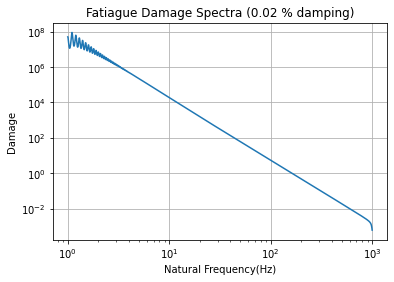

In [23]:
plt.loglog(fn,D); plt.grid(); plt.xlabel('Natural Frequency(Hz)'); plt.ylabel('Damage');
plt.title('Fatiague Damage Spectra (%.2f %% damping)'%(z));

In [24]:
outfilename = input('Enter output file name (e.g. fds.txt)');
fileO(fn,D,outfilename);
print(outfilename + ' is generated.');

Enter output file name (e.g. fds.txt)fds.txt
fds.txt is generated.
